In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
pip install pandas-datareader --upgrade

In [7]:
wlmrt = pdr.get_data_yahoo("WMT", 1970-7-25)

Text(0.5, 1.0, 'Wallmart Close Price history')

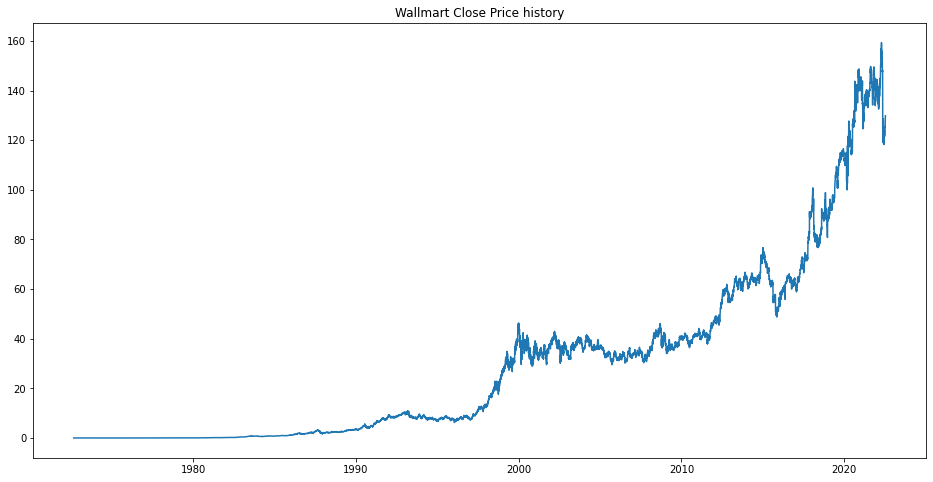

In [17]:
# wlmrt = wlmrt.reset_index()[['Date', 'Adj Close']]
# wlmrt.index=wlmrt['Date']
plt.figure(figsize=(16,8))
plt.plot(wlmrt["Adj Close"])
plt.title('Wallmart Close Price history')

In [26]:
data=wlmrt.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(wlmrt)),columns=['Date','Adj Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Adj Close"][i]=data["Adj Close"][i]

In [29]:
print(len(new_dataset)/2)
new_dataset = new_dataset.reset_index()

6290.5


In [30]:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:6290,:]
valid_data=final_dataset[6291:,:]

scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [61]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam', metrics = 'acc')

lstm_model.fit(x_train_data,y_train_data,epochs=2,batch_size=1,verbose=2)

Epoch 1/2
6230/6230 - 160s - loss: 7.1618e-06 - acc: 3.2103e-04 - 160s/epoch - 26ms/step
Epoch 2/2
6230/6230 - 154s - loss: 2.4930e-06 - acc: 3.2103e-04 - 154s/epoch - 25ms/step


In [62]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


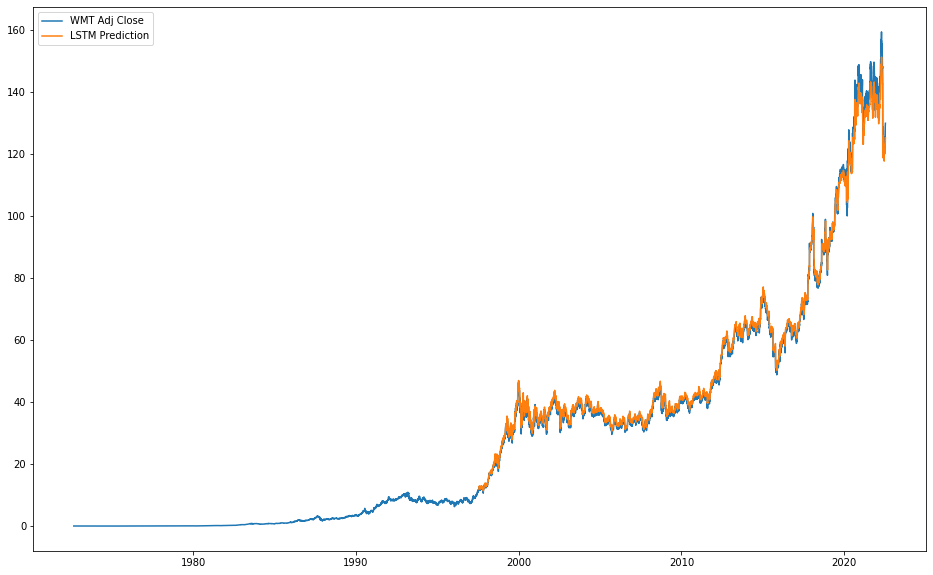

In [69]:
train_data=new_dataset[:6290]
valid_data=new_dataset[6291:]
valid_data['Predictions']=predicted_closing_price
plt.figure(figsize=(16,10))
plt.plot(new_dataset['Adj Close'], label = 'WMT Adj Close')
plt.plot(valid_data['Predictions'], label = 'LSTM Prediction')
plt.legend();

In [66]:
score = lstm_model.evaluate(x_train_data, y_train_data, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2012424122076482e-06
Test accuracy: 0.00032102729892358184
